In [1]:
import wrds
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

wrds_user = 'eiger'
wrds_password = 'Nordwand2011'

conn = wrds.Connection(wrds_username=wrds_user, wrds_password=wrds_password)

Loading library list...
Done


In [2]:
option_df = conn.raw_sql("""select date, exdate, cp_flag, strike_price, best_bid, best_offer from optionm.opprcd1996 where secid in (108105) and abs(delta) < 0.5""",date_cols=['date'])

for year in range(1997,2001): #smaller data set to work with at start
    df_new =conn.raw_sql("""select date, exdate, cp_flag, strike_price, best_bid, best_offer from optionm.opprcd"""+str(year)+""" where secid in (108105) and abs(delta) < 0.5""",date_cols=['date'])
    option_df = pd.concat([option_df,df_new])

In [3]:
option_df['date'] = pd.to_datetime(option_df['date'])
option_df['exdate'] = pd.to_datetime(option_df['exdate'])

option_df['days'] = (option_df['exdate'] - option_df['date']).dt.days

option_df['Q'] = 0.5*(option_df['best_bid'] + option_df['best_offer'])
option_df['strike_price'] = option_df['strike_price']/1000

option_df = option_df.drop(labels = ['best_offer','best_bid'],axis=1)


Get forward prices:

In [4]:
forward_df = conn.raw_sql("""select date, expiration as exdate, forwardprice as F from optionm.fwdprd1996 where secid in (108105)""",date_cols=['date'])
for year in range(1997,2001): #smaller data set to work with at start
    df_new = conn.raw_sql("""select date, expiration as exdate, forwardprice as F from optionm.fwdprd"""+str(year)+""" where secid in (108105)""",date_cols=['date'])
    forward_df = pd.concat([forward_df,df_new])
    
forward_df['date'] = pd.to_datetime(forward_df['date'])
forward_df['exdate'] = pd.to_datetime(forward_df['exdate'])

In [5]:
option_df = pd.merge(option_df,forward_df,how='left',on=['date','exdate'])

In [6]:
def GET_NEAR_NEXT(days,term):
    #NEAR
    near_cut = days[days<=term]
    if len(near_cut) == 0:
        near_cut = days
    near_idx = abs(near_cut - term).idxmin()
    near_days = days[near_idx]
    
    next_cut = days[days > near_days]
    next_idx = abs(next_cut - term).idxmin()
    next_days = days[next_idx]
    
    return near_days, next_days

In [7]:
DATES = option_df.date.unique()
term = 30

VX_swap = pd.DataFrame({'date':DATES,'near':None,'next':None,'RET':None})

for date in DATES:
    temp_df = option_df[option_df.date == date]
    
    near_days, next_days = GET_NEAR_NEXT(temp_df.days,term)
    VX_swap.loc[VX_swap.date == date, 'near'] = near_days
    VX_swap.loc[VX_swap.date == date, 'next'] = next_days

In [8]:
def GET_PORT_VAL(date_today,term,df):
    temp_df = df[(df.date == date_today) & (df.days == term)].sort_values(by='strike_price')
    
    if len(temp_df) == 0:
        P = 0
    else:
        temp_df['delta_k1'] = abs(temp_df.strike_price - temp_df.strike_price.shift(1,fill_value = np.inf))
        temp_df['delta_k2'] = abs(temp_df.strike_price - temp_df.strike_price.shift(-1,fill_value = np.inf))
        temp_df['port_val'] = temp_df.apply(lambda x: min(x[7],x[8])/(x[3]**2)*x[5],axis=1)
        P = temp_df.port_val.sum()
    
    return P

In [ ]:
N = len(DATES)

for idx in range(1,N):
    date_now = DATES[idx]
    date_prev = DATES[idx-1]
    days_diff = (date_now - date_prev).days
    
    [near_term,next_term] = VX_swap.iloc[idx-1,1:3].values
    
    P_next_prev = GET_PORT_VAL(date_prev,next_term,option_df)
    P_near_prev = GET_PORT_VAL(date_prev,near_term,option_df)
    
    P_next_now = GET_PORT_VAL(date_now,next_term-days_diff,option_df)
    P_near_now = GET_PORT_VAL(date_now,near_term-days_diff,option_df)
    
    if (P_next_now == 0 or P_near_now == 0):
        next
    else:
        w1 = (term - near_term)/(next_term - near_term)
        w2 = 1 - w1
        
        VX_swap.iloc[idx,3] = (w1 * P_next_now + w2 * P_near_now)/(w1 * P_next_prev + w2 * P_near_prev) - 1
        
VX_swap = VX_swap.dropna()

Read in authors data:

In [ ]:
VAR_SWAPS = pd.read_csv('VAR_SWAP_RET.csv',skiprows=5)

VAR_SWAPS = VAR_SWAPS.rename({'Date':'DATE','r_1^{var. swap}':'1 month','r_2^{var. swap}':'2 month','r_3^{var. swap}':'3 month',
                         'r_6^{var. swap}':'6 month','r_9^{var. swap}':'9 month','r_12^{var. swap}':'12 month'},axis=1)
def DATE_STR(num):
    num_str = str(num)
    date_str = num_str[-2:]+'/'+num_str[4:-2]+'/'+num_str[0:4]
    
    return date_str 

VAR_SWAPS['DATE'] = VAR_SWAPS['DATE'].apply(DATE_STR)
VAR_SWAPS['DATE'] = pd.to_datetime(VAR_SWAPS['DATE'],format = '%d/%m/%Y')

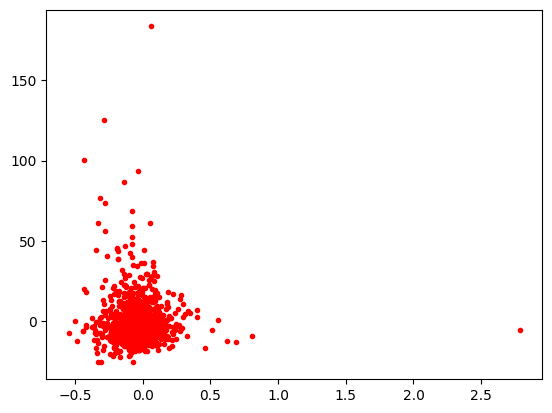

In [169]:
df1 = VAR_SWAPS[['DATE','1 month']]
df2 = VX_swap[['date','RET']].dropna()
df_check = pd.merge(df2,df1,left_on='date',right_on='DATE',how='left')
plt.plot(df_check['RET'],df_check['1 month'],'.r')

In [183]:
df_check.corr()

,date,RET,DATE,1 month
date,1.000000,-0.008044,1.000000,-0.009190
RET,-0.008044,1.000000,-0.008044,0.643916
DATE,1.000000,-0.008044,1.000000,-0.009190
1 month,-0.009190,0.643916,-0.009190,1.000000


Other method, getting just a portfolio value each day.

In [178]:
DATES = option_df.date.unique()
term = 30

VX_swap = pd.DataFrame({'date':DATES,'near':None,'next':None,'PORT_VAL':None,'RET':None})

for date in DATES:
    temp_df = option_df[option_df.date == date]
    
    near_days, next_days = GET_NEAR_NEXT(temp_df.days,term)
    VX_swap.loc[VX_swap.date == date, 'near'] = near_days
    VX_swap.loc[VX_swap.date == date, 'next'] = next_days

    
    
for idx in range(0,N):
    date = DATES[idx]
    
    [near_term,next_term] = VX_swap.iloc[idx,1:3].values
    
    P_next = GET_PORT_VAL(date,next_term,option_df)
    P_near = GET_PORT_VAL(date,near_term,option_df)
    
    w1 = (term - near_term)/(next_term - near_term)
    w2 = 1 - w1
        
    VX_swap.iloc[idx,3] = (w1 * P_next + w2 * P_near)
    


In [180]:
VX_swap['RET'] = (VX_swap['PORT_VAL'] / VX_swap['PORT_VAL'].shift(1) - 1)*100

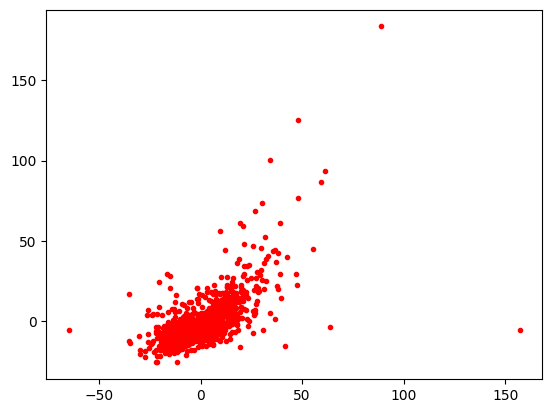

In [182]:
df1 = VAR_SWAPS[['DATE','1 month']]
df2 = VX_swap[['date','RET']].dropna()
df_check = pd.merge(df2,df1,left_on='date',right_on='DATE',how='left')
plt.plot(df_check['RET'],df_check['1 month'],'.r')